<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train/Test Split</a></span><ul class="toc-item"><li><span><a href="#SPY" data-toc-modified-id="SPY-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SPY</a></span></li><li><span><a href="#TNX" data-toc-modified-id="TNX-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>TNX</a></span></li><li><span><a href="#VIX" data-toc-modified-id="VIX-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>VIX</a></span></li><li><span><a href="#IRX" data-toc-modified-id="IRX-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>IRX</a></span></li></ul></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#Preprocess" data-toc-modified-id="Preprocess-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess</a></span></li><li><span><a href="#VIX" data-toc-modified-id="VIX-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>VIX</a></span></li><li><span><a href="#SPY" data-toc-modified-id="SPY-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SPY</a></span></li><li><span><a href="#TNX" data-toc-modified-id="TNX-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>TNX</a></span></li><li><span><a href="#IRX" data-toc-modified-id="IRX-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>IRX</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Fit the model

We explore the minutes and statements while we find them are not suitable for training and testing models. The sample size is too small, and the variance, or the principle generating documents, varies with time. Then we throw our sight on the speeches of federal reserve officials, which have more consistent length and contain more information.

We select four variables to sketch the effect of the FOMC's documents on the market: CBOE Volatility Index (VIX), S&P 500 Index(SPY), Treasury Yield 10 Years (TNX), Treasury Yield 3 months (IRX). The data are all from [Yahoo Finance](https://finance.yahoo.com/).

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, concatenate, Activation, Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from frb_functions import plot_speeches_per_year

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [2]:
spy_df = pd.read_csv('./data/SPY.csv')
spy_df.fillna(method='pad')
spy_df["SPY"] = spy_df["Adj Close"].pct_change() * 100
spy_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
spy_df.drop(0, inplace=True)
vix_df = pd.read_csv('./data/^VIX.csv')
vix_df.fillna(method='pad')
vix_df["VIX"] = vix_df["Adj Close"].pct_change() * 100
vix_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
vix_df.drop(0, inplace=True)
tnx_df = pd.read_csv('./data/^TNX.csv')
tnx_df.fillna(method='pad')
tnx_df["TNX"] = tnx_df["Adj Close"].pct_change() * 100
tnx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
tnx_df.drop(0, inplace=True)
irx_df = pd.read_csv('./data/^IRX.csv')
irx_df.fillna(method='pad')
irx_df["IRX"] = irx_df["Adj Close"].pct_change() * 100
irx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
irx_df.drop(0, inplace=True)

In [3]:
mkt_df = pd.merge(spy_df, vix_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, tnx_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, irx_df, how='left', on='Date')
mkt_df.rename(columns={'Date': 'date'}, inplace=True)
mkt_df['date'] = pd.to_datetime(mkt_df['date'])

Then we crawl the speeches' full text from the [FED official website](https://www.federalreserve.gov/newsevents/speeches.htm)

In [4]:
# speech_urls = navigate_frb_speeches()
# speeches = get_frb_speech_text(speech_urls)
# speeches_df = pd.DataFrame(frb_articles, columns=['url', 'speech_date', 'title', 'speaker', 'location', 'full_text'])
# speech_urls, speakers, locations, dates_, titles = navigate_frb_archived_speeches()
# speech_text = get_frb_speech_text_archived(speech_urls)
# archived_speeches = list(zip(speech_urls, dates_, titles, speakers, locations, speech_text))
# archived_speeches_df = pd.DataFrame(archived_speeches, columns=['url', 'speech_date', 'title', 'speaker', 'location', 'full_text'])
# df_raw = pd.concat([speeches_df, archived_speeches_df])
# df_raw.to_pickle('/data/frb_speeches_all_raw.pkl')

In [5]:
df_raw = pd.read_pickle('./data/frb_speeches_all_raw.pkl')
# df_raw.shape

In [6]:
df_raw["number of words"] = df_raw["full_text"].apply(lambda x: sum(len(y.split()) for y in x.split('.')))
df_raw["number of sentences"] = df_raw["full_text"].apply(lambda x: len(x.split('.')))
df_raw['speech_date'] = pd.to_datetime(df_raw['speech_date'])

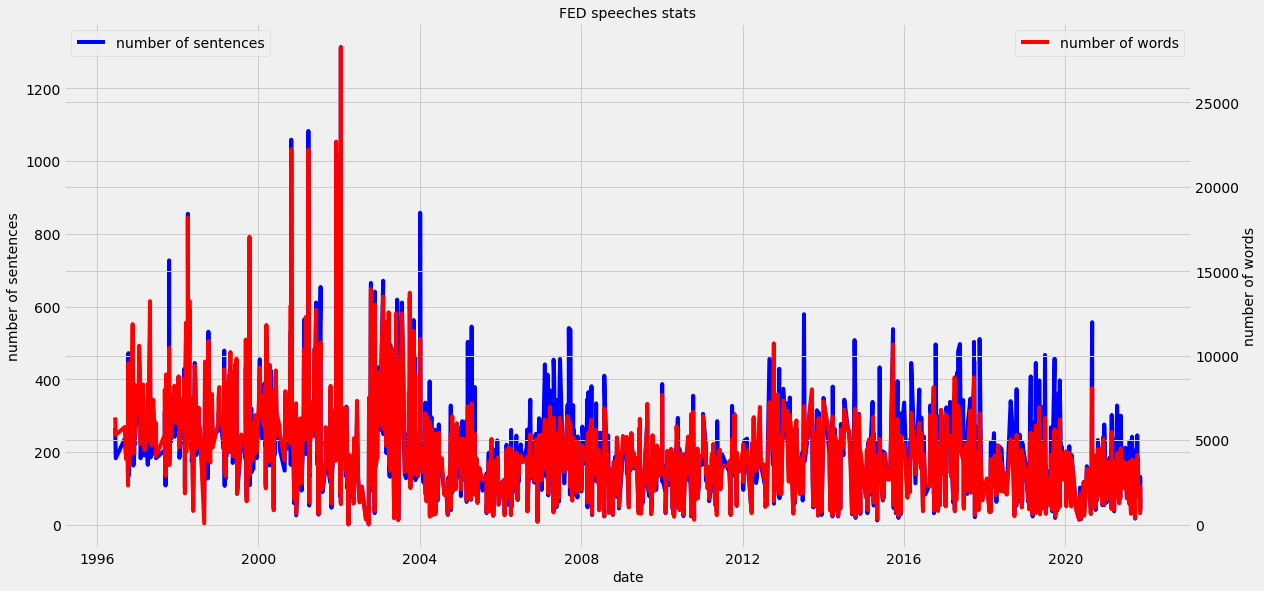

In [7]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df_raw['speech_date'], df_raw["number of sentences"], 'b', label='number of sentences')
ax2.plot(df_raw['speech_date'], df_raw["number of words"], 'r', label='number of words')
plt.title('FED speeches stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

As shown above, the number of sentences and words included in the speeches' full text are highly correlated. Also, the length of the speeches' full text doesn't vary much because the time of address is limited.

In [8]:
# df_speech = clean_speech_text(df_raw)
# df_speech.to_pickle("./data/frb_speeches_all.pkl")

In [9]:
df_speech = pd.read_pickle("./data/frb_speeches_all.pkl")
df_speech['speech_year'] = df_speech['speech_date'].str[-4:]
df_speech.drop(columns=['url', 'title', 'speaker', 'location'], inplace=True)
df_speech["speech_date"] = pd.to_datetime(df_speech["speech_date"])
df_speech.rename(columns={'speech_date': 'date'}, inplace=True)
df_speech = pd.merge(df_speech, mkt_df, how='left', on='date')
df_speech.dropna(inplace=True)
df_speech.reset_index(inplace=True, drop=True)

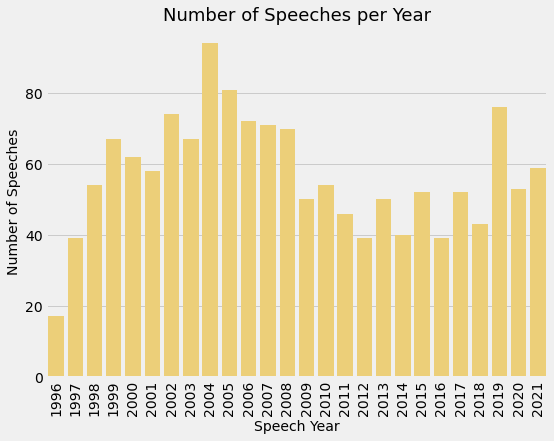

In [10]:
plot_speeches_per_year(df_speech)

Then we divide the market movement into two categories: 1 for upward and 0 for the rest.

In [11]:
for var in df_speech.columns[-4:]:
    df_speech[var] = df_speech[var].apply(lambda x: 1 if x > 0 else 0)

## Train/Test Split

The ratio I decided to split my data is 80/20, 80% of data as the training set, and 20% for the test set. The summary of the data split is given in the following cells.

In [12]:
def set_des(x_train_set, x_test_set, y_train_set, y_test_set):
    print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
        len(x_train_set), (len(x_train_set[y_train_set == 0]) / (len(x_train_set) * 1.)) * 100, (
                len(x_train_set[y_train_set == 1]) / (len(x_train_set) * 1.)) * 100))
    print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
        len(x_test_set), (len(x_test_set[y_test_set == 0]) / (len(x_test_set) * 1.)) * 100, (
                len(x_test_set[y_test_set == 1]) / (len(x_test_set) * 1.)) * 100))

### SPY

In [13]:
x = df_speech['full_text']
y = df_speech['SPY']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 45.31% negative, 54.69% positive
Test set has total 296 entries with 49.66% negative, 50.34% positive


### TNX

In [14]:
x = df_speech['full_text']
y = df_speech['TNX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 51.56% negative, 48.44% positive
Test set has total 296 entries with 52.36% negative, 47.64% positive


### VIX

In [15]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 56.30% negative, 43.70% positive
Test set has total 296 entries with 53.04% negative, 46.96% positive


### IRX

In [16]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 56.30% negative, 43.70% positive
Test set has total 296 entries with 53.04% negative, 46.96% positive


## Methodology

We have four y variables, and we apply two typical models: `tf-idf` & `logit` model and `word2vec` & `CNN` model on them. The CNN architecture we will implement below is inspired by [Zhang, Y., & Wallace, B. (2015)](https://arxiv.org/pdf/1510.03820.pdf). The structure is as the following figure.

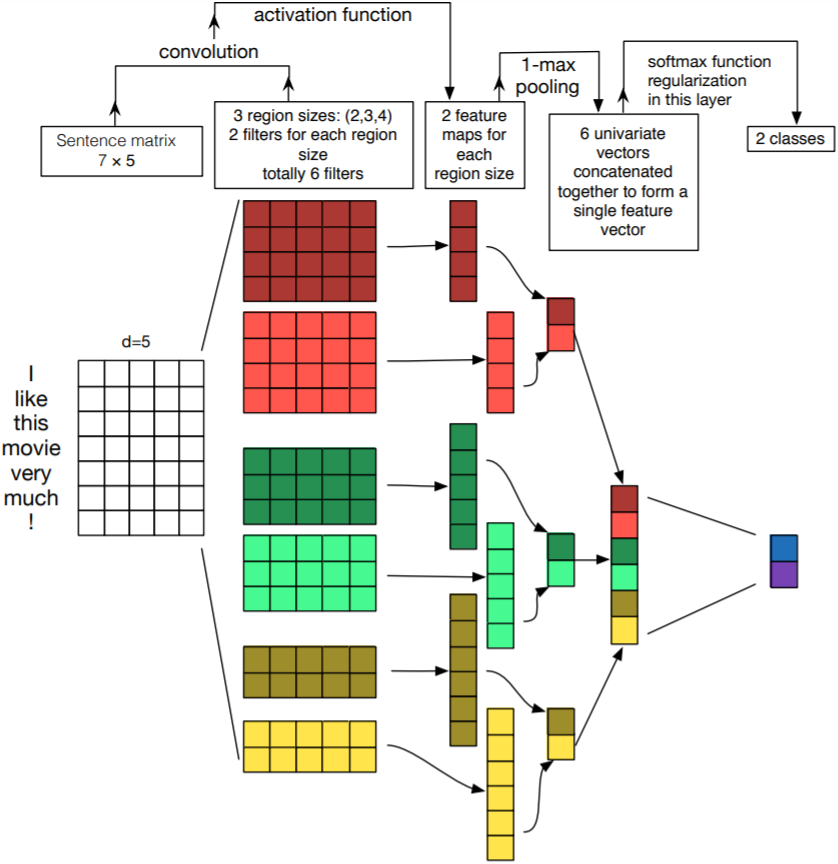

### Preprocess

In [17]:
def labelize_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [18]:
all_x_w2v = labelize_ug(x, 'all')

In [19]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<?, ?it/s]


In [21]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1485127.03it/s]


Wall time: 53.2 s


In [22]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1474887.21it/s]


In [23]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1505308.33it/s]


Wall time: 56.2 s


In [24]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 27847 word vectors.


In [25]:
model_ug_cbow.save('./model/w2v_model_ug_cbow.word2vec')
model_ug_sg.save('./model/w2v_model_ug_sg.word2vec')

In [26]:
model_ug_cbow = KeyedVectors.load('./model/w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('./model/w2v_model_ug_sg.word2vec')

### VIX

In [27]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 56.30% negative, 43.70% positive
Test set has total 296 entries with 53.04% negative, 46.96% positive


In [28]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [29]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

In [30]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
sequences = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(sequences, maxlen=len(length))
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1183)


In [32]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))

In [33]:
tweet_input = Input(shape=(len(length)), dtype='int32')

tweet_encoder = Embedding(10000, 200, weights=[embedding_matrix], input_length=len(length), trainable=True)(
    tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1183)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1183, 200)    2000000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 1182, 100)    40100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1181, 100)    60100       ['embedding[0][0]']              
                                                                                              

In [34]:
filepath = "./model/CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.4903
Epoch 00001: val_accuracy improved from -inf to 0.49662, saving model to ./model\CNN_best_weights.01-0.4966.hdf5
37/37 [==============================] - 10s 250ms/step - loss: 1.3395 - accuracy: 0.4903 - val_loss: 0.7114 - val_accuracy: 0.4966
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.6078
Epoch 00002: val_accuracy improved from 0.49662 to 0.50000, saving model to ./model\CNN_best_weights.02-0.5000.hdf5
37/37 [==============================] - 9s 243ms/step - loss: 0.6951 - accuracy: 0.6078 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.7473
Epoch 00003: val_accuracy improved from 0.50000 to 0.51014, saving model to ./model\CNN_best_weights.03-0.5101.hdf5
37/37 [==============================] - 9s 241ms/step - loss: 0.5037 - accuracy: 0.7473 - val_loss: 0.7421 - val

In [35]:
loaded_CNN_model = load_model('./model/CNN_best_weights.05-0.5304.hdf5')

In [36]:
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
tvec.fit(x_train)
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [37]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)
lr_with_tfidf.score(x_test_tfidf, y_test)

0.5304054054054054

In [38]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

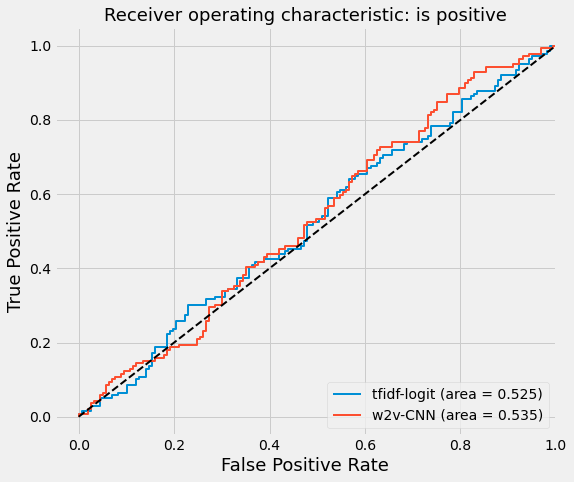

In [39]:
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### SPY

In [40]:
x = df_speech['full_text']
y = df_speech['SPY']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 45.31% negative, 54.69% positive
Test set has total 296 entries with 49.66% negative, 50.34% positive


In [41]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

In [42]:
sequences = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(sequences, maxlen=len(length))
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1183)


In [43]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))

In [44]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.3846
Epoch 00001: val_accuracy improved from -inf to 0.50338, saving model to ./model\CNN_best_weights.01-0.5034.hdf5
37/37 [==============================] - 9s 244ms/step - loss: 1.0548 - accuracy: 0.3846 - val_loss: 0.7503 - val_accuracy: 0.5034
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.5393
Epoch 00002: val_accuracy did not improve from 0.50338
37/37 [==============================] - 9s 249ms/step - loss: 0.7039 - accuracy: 0.5393 - val_loss: 0.7151 - val_accuracy: 0.5034
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.5833
Epoch 00003: val_accuracy did not improve from 0.50338
37/37 [==============================] - 9s 251ms/step - loss: 0.6702 - accuracy: 0.5833 - val_loss: 0.7182 - val_accuracy: 0.5034
Epoch 4/5
37/37 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.6492
Epoch 00004:

In [45]:
loaded_CNN_model = load_model('./model/CNN_best_weights.05-0.5338.hdf5')

In [46]:
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
tvec.fit(x_train)
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [47]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)
lr_with_tfidf.score(x_test_tfidf, y_test)

0.4831081081081081

In [48]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

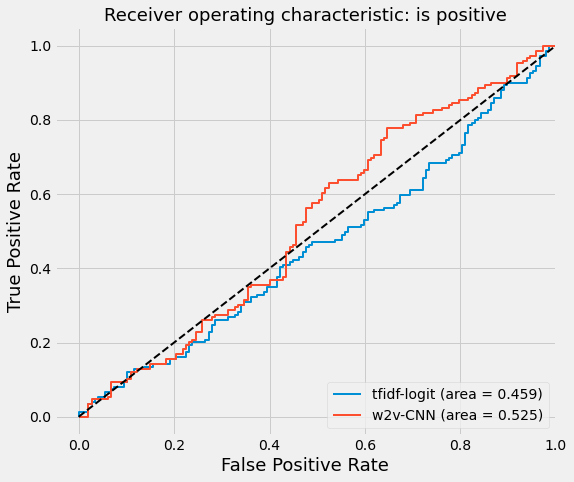

In [49]:
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### TNX

In [50]:
x = df_speech['full_text']
y = df_speech['TNX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 51.56% negative, 48.44% positive
Test set has total 296 entries with 52.36% negative, 47.64% positive


In [51]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

In [52]:
sequences = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(sequences, maxlen=len(length))
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1183)


In [53]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))

In [55]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.5900
Epoch 00001: val_accuracy improved from -inf to 0.50676, saving model to ./model\CNN_best_weights.01-0.5068.hdf5
37/37 [==============================] - 9s 253ms/step - loss: 0.6668 - accuracy: 0.5900 - val_loss: 0.6926 - val_accuracy: 0.5068
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6788
Epoch 00002: val_accuracy improved from 0.50676 to 0.54392, saving model to ./model\CNN_best_weights.02-0.5439.hdf5
37/37 [==============================] - 10s 259ms/step - loss: 0.6213 - accuracy: 0.6788 - val_loss: 0.6930 - val_accuracy: 0.5439
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.7768
Epoch 00003: val_accuracy did not improve from 0.54392
37/37 [==============================] - 9s 247ms/step - loss: 0.5482 - accuracy: 0.7768 - val_loss: 0.6956 - val_accuracy: 0.5135
Epoch 4/5
37/37 [==========================

In [56]:
loaded_CNN_model = load_model('./model/CNN_best_weights.02-0.5439.hdf5')

In [57]:
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
tvec.fit(x_train)
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [58]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)
lr_with_tfidf.score(x_test_tfidf, y_test)

0.46959459459459457

In [59]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

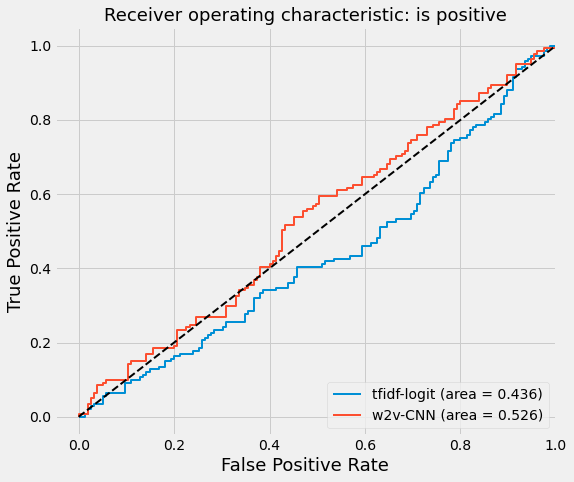

In [60]:
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### IRX

In [61]:
x = df_speech['full_text']
y = df_speech['IRX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 61.88% negative, 38.12% positive
Test set has total 296 entries with 59.12% negative, 40.88% positive


In [62]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

In [63]:
sequences = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(sequences, maxlen=len(length))
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1183)


In [64]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))

In [65]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.6128
Epoch 00001: val_accuracy improved from -inf to 0.59122, saving model to ./model\CNN_best_weights.01-0.5912.hdf5
37/37 [==============================] - 9s 253ms/step - loss: 0.7119 - accuracy: 0.6128 - val_loss: 0.6846 - val_accuracy: 0.5912
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.6932
Epoch 00002: val_accuracy did not improve from 0.59122
37/37 [==============================] - 9s 257ms/step - loss: 0.5949 - accuracy: 0.6932 - val_loss: 0.7130 - val_accuracy: 0.5878
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7430
Epoch 00003: val_accuracy did not improve from 0.59122
37/37 [==============================] - 9s 254ms/step - loss: 0.5361 - accuracy: 0.7430 - val_loss: 0.7061 - val_accuracy: 0.5777
Epoch 4/5
37/37 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8428
Epoch 00004:

In [66]:
loaded_CNN_model = load_model('./model/CNN_best_weights.01-0.5912.hdf5')

In [67]:
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
tvec.fit(x_train)
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [68]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)
lr_with_tfidf.score(x_test_tfidf, y_test)

0.5912162162162162

In [69]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length))
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

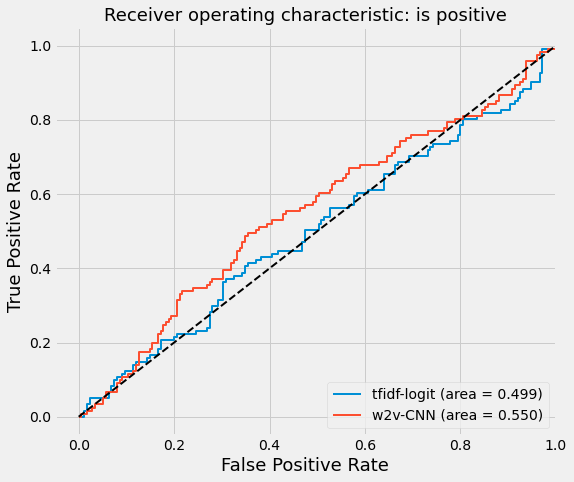

In [70]:
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Conclusion

It seems that the market had seen right through the FED. We cannot predict precisely the market reaction based on the FED's newly released speech context. The result is much worse than expected, which is similar to random guessing, especially for those more stable variables. We can only find a little faith from the test result on the treasury three months yield. Intuitively, the monetary policy is endogenous for the market, so the chances are that the market has a fair expectation for the FED's actions. Usually, the speech is under a given topic, and the market can imagine what the officials will say. Mr. Market obtained nothing new related to long-term policy trends since solo officials can determine the long-term policy impossibly.

Though the result is terrible, we cannot assert that the market is inefficient. By contrast, the market is much more efficient because, during the exploring data, we find great accuracy in predicting the market based on the FOMC meeting minutes. Unfortunately, as we introduced in the previous notebook, the minutes are not public until three weeks after the meeting. (Hence, we ignore this part here.) Mr. Market knows the thing unknown for us. We should always respect Mr. Market!

## Reference

1. Zhang, Y., & Wallace, B. (2015). A sensitivity analysis of (and practitioners' guide to) convolutional neural networks for sentence classification. arXiv preprint arXiv:1510.03820.